# SCA koriscenjem deep learninga

U radu je do sada bilo prikazano nekoliko nacina izvlacenja tajni iz hardvera. State of the art pristup su template napadi koji su se pokazali kao standard u ovoj oblasti istrazivanja sigurnosti sistema. Kod template napada je potrebno ozbiljno preprocesiranje ulaznih podataka, potrebno je dosta iskustva. DPA i CPA su dovoljno jednostavni za koriscenje i implementaciju, ali je i za njih potreban relativno veliki broj trace-va i ne pokazuju se toliko dobro sa sumovitim podacima. Deep learning nastoji da eliminise neke od navedenih problema. 

# Arhitekture neuronskih mreza koje ce biti koriscene

U radu koji opisuje ASCAD bazu podataka date su i neke smernice oko odabira odgovarajucih modela i izbora hiperparametara. Preprocesiranje podataka i redukcija dimenzionalnosti nije potrebna, jer se ona obavi u prvim slojevima mreze.
Architecture choice is a difficult topic...

## MLP (multi-layered perceptron)

Obicna potpuno povezana neuronska mreza sa softmax aktivacijom. Broj slojeva i neurona po slojevima je tesko odrediti kao sto ce se videti u nastavku.

input sloj : 80.000 tacaka traceva
output sloj : 256 klasa za 256 mogucih vrednosti jednog bajta kljuca

In [3]:
import random
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import os
import numpy as np
import h5py
import tensorflow as tf
import keras
from datetime import datetime
import keras_tuner as kt
from tqdm.notebook import tqdm

C:\Users\avra\Miniconda3\envs\ML-SCA\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Train on SCAAML dataset

In [4]:
from utils.data_preparation import SCAML_Dataset

In [5]:
EXECUTE_IN_COLAB = False
ATTACK_ALGORITHM = 'tinyaes'

if EXECUTE_IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    
    data_root_path = '/content/drive/MyDrive/datasets/'
    log_root_path ='/content/drive/MyDrive/logs/'
    
    training_data_path = data_root_path + ATTACK_ALGORITHM + '/train'
    testing_data_path =  data_root_path + ATTACK_ALGORITHM + '/test'
else:    
    data_root_path = './data/SCA_datasets/datasets/' + ATTACK_ALGORITHM
    log_root_path = './logs/'
    
    training_data_path = data_root_path + '/train'
    testing_data_path = data_root_path + '/test'

In [6]:
dataset = SCAML_Dataset()

training_array = dataset.load_shards(training_data_path)
testing_array = dataset.load_shards(testing_data_path)

ATTACK_POINT = 'sub_bytes_out'
ATTACK_BYTE = 0

256it [00:01, 130.47it/s]
256it [00:01, 130.14it/s]


In [56]:
(X_train, y_train) = dataset.create_data(training_array, ATTACK_POINT, ATTACK_BYTE, 10000)
(X_test, y_test, keys, plaintexts) = dataset.create_data(testing_array, ATTACK_POINT, ATTACK_BYTE, 10000, attack = True)

256it [00:01, 143.73it/s]
256it [00:01, 158.68it/s]
Loading shards: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:59<00:00,  4.29it/s]


In [10]:
input_vector_shape = X_train.shape[1]

### Create and train MLP

In [6]:
# Input
inputs = keras.Input(shape = (input_vector_shape,))

# Hidden layer 1
x = keras.layers.Dense(name='hidden_layer_1', units=200, activation='relu')(inputs)

# Hidden layer 2
x = keras.layers.Dense(name='hidden_layer_2', units=200, activation='relu')(x)

# Hidden layer 3
x = keras.layers.Dense(name='hidden_layer_3', units=200, activation='relu')(x)

# Hidden layer 4
x = keras.layers.Dense(name='hidden_layer_4', units=200, activation='relu')(x)

# Hidden layer 5
x = keras.layers.Dense(name='hidden_layer_5', units=200, activation='relu')(x)

# Output layer
outputs = keras.layers.Dense(name='output_layer', units=256, activation='softmax')(x)

MLP = keras.Model(inputs=inputs, outputs=outputs, name='MLP_base_SCAAML')

MLP.summary()

Model: "MLP_base_SCAAML"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10000)]           0         
                                                                 
 hidden_layer_1 (Dense)      (None, 200)               2000200   
                                                                 
 hidden_layer_2 (Dense)      (None, 200)               40200     
                                                                 
 hidden_layer_3 (Dense)      (None, 200)               40200     
                                                                 
 hidden_layer_4 (Dense)      (None, 200)               40200     
                                                                 
 hidden_layer_5 (Dense)      (None, 200)               40200     
                                                                 
 output_layer (Dense)        (None, 256)           

In [ ]:
#TODO: create before writing
# model_img_path = './images/' + MLP.name
# tf.keras.utils.plot_model(MLP, show_shapes=True, to_file=model_img_path)

In [7]:
MLP_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001)

MLP.compile(loss='categorical_crossentropy', 
                 optimizer=MLP_optimizer, 
                 metrics=['accuracy'])

In [23]:
_log_dir = log_root_path + 'MLP_' + datetime.now().strftime("%Y-%d-%m_%H-%M")

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3),
    tf.keras.callbacks.TensorBoard(log_dir=_log_dir, histogram_freq=1)
]

history = MLP.fit(X_train, y_train, batch_size=32, epochs=50, verbose=1, validation_data=(X_test, y_test), callbacks=callbacks_list)

Epoch 1/50
2048/2048 [==============================] - 37s 18ms/step - loss: 5.5451 - accuracy: 0.0036 - val_loss: 5.5451 - val_accuracy: 0.0039
Epoch 2/50
2048/2048 [==============================] - 47s 23ms/step - loss: 5.5451 - accuracy: 0.0035 - val_loss: 5.5451 - val_accuracy: 0.0039
Epoch 3/50
2048/2048 [==============================] - 55s 27ms/step - loss: 5.5451 - accuracy: 0.0036 - val_loss: 5.5451 - val_accuracy: 0.0039
Epoch 4/50
2048/2048 [==============================] - 52s 26ms/step - loss: 5.5451 - accuracy: 0.0032 - val_loss: 5.5451 - val_accuracy: 0.0039
Epoch 5/50
2048/2048 [==============================] - 35s 17ms/step - loss: 5.5451 - accuracy: 0.0037 - val_loss: 5.5451 - val_accuracy: 0.0039


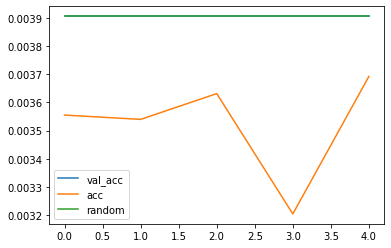

In [26]:
random_accuracy = [1/256] * len(history.history['val_accuracy'])

plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.plot(random_accuracy)
plt.legend(['val_acc', 'acc', 'random'],loc='best')
plt.show()

Model gotovo nista nije naucio i preciznost je cak i gora od nasumicnog pogadjanja (1/256 ~ 0.0039)
Stoga nema puno smisla evaluirati model i vrsiti kriptografske transformacije kako bi se otkrio kljuc.

#### Batch normalization

In [30]:
# Input
inputs = keras.Input(shape = (input_vector_shape,))

# Hidden layer 1
x = keras.layers.Dense(name='hidden_layer_1', units=200, activation='relu')(inputs)

# Hidden layer 2
x = keras.layers.Dense(name='hidden_layer_2', units=200, activation='relu')(x)

# Batch normalization 1
x = keras.layers.BatchNormalization()(x)

# Hidden layer 3
x = keras.layers.Dense(name='hidden_layer_3', units=200, activation='relu')(x)

# Hidden layer 4
x = keras.layers.Dense(name='hidden_layer_4', units=200, activation='relu')(x)

# Batch normalization 2
x = keras.layers.BatchNormalization()(x)

# Hidden layer 5
x = keras.layers.Dense(name='hidden_layer_5', units=200, activation='relu')(x)

# Output layer
outputs = keras.layers.Dense(name='output_layer', units=256, activation='softmax')(x)

MLP_batchnorm = keras.Model(inputs=inputs, outputs=outputs, name='MLP_batch_norm_SCAAML')

MLP_batchnorm.summary()

Model: "MLP_batch_norm_SCAAML"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 10000)]           0         
                                                                 
 hidden_layer_1 (Dense)      (None, 200)               2000200   
                                                                 
 hidden_layer_2 (Dense)      (None, 200)               40200     
                                                                 
 batch_normalization_4 (Batc  (None, 200)              800       
 hNormalization)                                                 
                                                                 
 hidden_layer_3 (Dense)      (None, 200)               40200     
                                                                 
 hidden_layer_4 (Dense)      (None, 200)               40200     
                                             

In [31]:
MLP_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001)

MLP_batchnorm.compile(loss='categorical_crossentropy', 
                 optimizer=MLP_optimizer, 
                 metrics=['accuracy'])

In [33]:
_log_dir = log_root_path + 'MLP_batchnorm_' + datetime.now().strftime("%Y-%d-%m_%H-%M")

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3),
    tf.keras.callbacks.TensorBoard(log_dir=_log_dir, histogram_freq=1)
]

history = MLP_batchnorm.fit(X_train, y_train, batch_size=32, epochs=50, verbose=1, validation_data=(X_test, y_test), callbacks=callbacks_list)

Epoch 1/50
2048/2048 [==============================] - 44s 21ms/step - loss: 5.6576 - accuracy: 0.0039 - val_loss: 5.8534 - val_accuracy: 0.0039
Epoch 2/50
2048/2048 [==============================] - 57s 28ms/step - loss: 5.5939 - accuracy: 0.0041 - val_loss: 5.6904 - val_accuracy: 0.0035
Epoch 3/50
2048/2048 [==============================] - 44s 22ms/step - loss: 5.5705 - accuracy: 0.0045 - val_loss: 5.6313 - val_accuracy: 0.0040
Epoch 4/50
2048/2048 [==============================] - 44s 22ms/step - loss: 5.4226 - accuracy: 0.0109 - val_loss: 5.4063 - val_accuracy: 0.0085
Epoch 7/50
2048/2048 [==============================] - 53s 26ms/step - loss: 5.2037 - accuracy: 0.0170 - val_loss: 5.0885 - val_accuracy: 0.0168
Epoch 8/50
2048/2048 [==============================] - 47s 23ms/step - loss: 4.9150 - accuracy: 0.0258 - val_loss: 4.8603 - val_accuracy: 0.0249
Epoch 9/50
2048/2048 [==============================] - 51s 25ms/step - loss: 4.6056 - accuracy: 0.0407 - val_loss: 4.7903 -

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2048/2048 [==============================] - 54s 26ms/step - loss: 2.8744 - accuracy: 0.1710 - val_loss: 2.7494 - val_accuracy: 0.1536
Epoch 27/50
2048/2048 [==============================] - 51s 25ms/step - loss: 2.8174 - accuracy: 0.1802 - val_loss: 2.9406 - val_accuracy: 0.1350
Epoch 29/50
2048/2048 [==============================] - 52s 26ms/step - loss: 2.8148 - accuracy: 0.1805 - val_loss: 2.5529 - val_accuracy: 0.1924
Epoch 30/50
2048/2048 [==============================] - 41s 20ms/step - loss: 2.7973 - accuracy: 0.1841 - val_loss: 2.5655 - val_accuracy: 0.2067
Epoch 31/50
2048/2048 [==============================] - 54s 26ms/step - loss: 2.7756 - accuracy: 0.1912 - val_loss: 2.4140 - val_accuracy: 0.2223
Epoch 32/50
2048/2048 [==============================] - 48s 24ms/step - loss: 2.7535 - accuracy: 0.1924 - val_loss: 2.5254 - val_accuracy: 0.2147
Epoch 33/50
2048/2048 [==============================] - 47s 23ms/step - loss: 2.7513 - accuracy: 0.1955 - val_loss: 2.8140 - val_

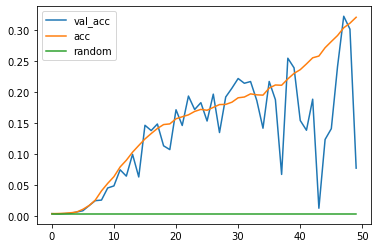

In [34]:
random_accuracy = [1/256] * len(history.history['val_accuracy'])

plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.plot(random_accuracy)
plt.legend(['val_acc', 'acc', 'random'],loc='best')
plt.show()

In [35]:
MLP_batchnorm.save('./models/MLP_batchnorm_0.0')

INFO:tensorflow:Assets written to: ./models/MLP_batchnorm_0.0\assets


### Evaluate the model

In [11]:
MLP_batchnorm_loaded = tf.keras.models.load_model('./models/MLP_batchnorm_0.0')

In [59]:
ATTACK_TRACE = 23

In [60]:
attack_traces = X_test[ATTACK_TRACE*256:ATTACK_TRACE*256+256,:,:]

In [71]:
true_labels = np.argmax(y_test[ATTACK_TRACE*256:ATTACK_TRACE*256+256,:], axis=1)

In [68]:
predictions = MLP_batchnorm_loaded.predict(attack_traces)

In [31]:
# Now the single key should be attacked => no shuffling!!!
# Attack will always be on the same shard!!!

(10, 256)

In [69]:
predicted_labels = np.argmax(predictions, axis=1)

In [73]:
np.sum(predicted_labels == true_labels, axis=0)

18

In [36]:
class AES():
  """! AES algorithm partial implementation
  Used for key recovery
  """

  AES_SBOX = [
    # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f 
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76, # 0
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0, # 1
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15, # 2
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75, # 3
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84, # 4
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf, # 5
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8, # 6
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2, # 7
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73, # 8
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb, # 9
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79, # a
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08, # b
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a, # c
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e, # d
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf, # e
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16  # f
  ]

  AES_SBOX_INVERSE = [
      # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f 
      0x52,0x09,0x6a,0xd5,0x30,0x36,0xa5,0x38,0xbf,0x40,0xa3,0x9e,0x81,0xf3,0xd7,0xfb, # 0
      0x7c,0xe3,0x39,0x82,0x9b,0x2f,0xff,0x87,0x34,0x8e,0x43,0x44,0xc4,0xde,0xe9,0xcb, # 1
      0x54,0x7b,0x94,0x32,0xa6,0xc2,0x23,0x3d,0xee,0x4c,0x95,0x0b,0x42,0xfa,0xc3,0x4e, # 2
      0x08,0x2e,0xa1,0x66,0x28,0xd9,0x24,0xb2,0x76,0x5b,0xa2,0x49,0x6d,0x8b,0xd1,0x25, # 3
      0x72,0xf8,0xf6,0x64,0x86,0x68,0x98,0x16,0xd4,0xa4,0x5c,0xcc,0x5d,0x65,0xb6,0x92, # 4
      0x6c,0x70,0x48,0x50,0xfd,0xed,0xb9,0xda,0x5e,0x15,0x46,0x57,0xa7,0x8d,0x9d,0x84, # 5
      0x90,0xd8,0xab,0x00,0x8c,0xbc,0xd3,0x0a,0xf7,0xe4,0x58,0x05,0xb8,0xb3,0x45,0x06, # 6
      0xd0,0x2c,0x1e,0x8f,0xca,0x3f,0x0f,0x02,0xc1,0xaf,0xbd,0x03,0x01,0x13,0x8a,0x6b, # 7
      0x3a,0x91,0x11,0x41,0x4f,0x67,0xdc,0xea,0x97,0xf2,0xcf,0xce,0xf0,0xb4,0xe6,0x73, # 8
      0x96,0xac,0x74,0x22,0xe7,0xad,0x35,0x85,0xe2,0xf9,0x37,0xe8,0x1c,0x75,0xdf,0x6e, # 9
      0x47,0xf1,0x1a,0x71,0x1d,0x29,0xc5,0x89,0x6f,0xb7,0x62,0x0e,0xaa,0x18,0xbe,0x1b, # a
      0xfc,0x56,0x3e,0x4b,0xc6,0xd2,0x79,0x20,0x9a,0xdb,0xc0,0xfe,0x78,0xcd,0x5a,0xf4, # b
      0x1f,0xdd,0xa8,0x33,0x88,0x07,0xc7,0x31,0xb1,0x12,0x10,0x59,0x27,0x80,0xec,0x5f, # c
      0x60,0x51,0x7f,0xa9,0x19,0xb5,0x4a,0x0d,0x2d,0xe5,0x7a,0x9f,0x93,0xc9,0x9c,0xef, # d
      0xa0,0xe0,0x3b,0x4d,0xae,0x2a,0xf5,0xb0,0xc8,0xeb,0xbb,0x3c,0x83,0x53,0x99,0x61, # e
      0x17,0x2b,0x04,0x7e,0xba,0x77,0xd6,0x26,0xe1,0x69,0x14,0x63,0x55,0x21,0x0c,0x7d  # f
  ]

  def process_aes(self, input_byte, key_byte):
    """! Execute single SBOX operation
    @param input_byte Plain text byte
    @param key_byte Secret key byte
    @return Output of the SBOX applied to XOR-ed inputs
    """
    sbox_input = input_byte ^ key_byte
    return self.AES_SBOX[sbox_input]

  def reverse_aes(self, sbox_out, plain_byte):
    """! Perform reverse AES SBOX operation
    @param sbox_out Output of the SBOX
    @param plain_byte Plain text byte
    @return Input of the SBOX based on the outputs
    """
    key_byte = self.AES_SBOX_INVERSE[sbox_out] ^ plain_byte
    return key_byte

In [37]:
from collections import defaultdict

y_pred = []
y_true = []
model_metrics = {"acc": tf.metrics.Accuracy()}
correct_prediction_rank = defaultdict(list)
aes = AES()

In [95]:
for attack_trace in tqdm(range(256)):
    attack_traces = X_test[attack_trace*256:attack_trace*256+256,:,:]
    predictions = MLP_batchnorm_loaded.predict(attack_traces)
    
    predictions_cat = np.argmax(predictions, axis=1)
    true_labels = np.argmax(y_test[attack_trace*256:attack_trace*256+256,:], axis=1)
    
    key_preds = []
    for s, p in zip(predictions_cat, plaintexts):
        aes.reverse_aes(s, p)
    
    for metric in model_metrics.values():
        metric.update_state(true_labels, predictions_cat)
    # for the confusion matrix
    y_pred.extend(predictions_cat)
    y_true.extend(true_labels)
        
    key = keys[0] # all the same in the same shard - not used in real attack
    vals = np.zeros((256))
    for trace_count, kp in enumerate(key_preds):
        vals = vals  + np.log10(kp + 1e-22) 
        guess_ranks = (np.argsort(vals, )[-256:][::-1])
        byte_rank = list(guess_ranks).index(key)
        correct_prediction_rank[trace_count].append(byte_rank)

  0%|          | 0/256 [00:00<?, ?it/s]

In [109]:
print(f"{model_metrics['acc'].result()}")

0.07745361328125


In [40]:
def plot_confusion_matrix(class_ids,
                          predicted_class_ids,
                          title="Confusion matrix",
                          cmap=None,
                          normalize=True):
    """ Compute and plot the confusion matrix
    Args:
        class_ids (list(int)): Expected values
        predicted_class_ids (list(int)): predicted values
        cmap ([type], optional): Color map. Defaults to None.
        normalize (bool, optional): Normalize value between 0 and 1.
        Defaults to True.
    """

    cm = np.array(tf.math.confusion_matrix(class_ids, predicted_class_ids))
    # accuracy = np.trace(cm) / np.sum(cm).astype("float")

    if cmap is None:
        cmap = plt.get_cmap("Blues")

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.tight_layout()
    plt.ylabel("True intermediate values")
    plt.xlabel("Predicted intermediate values")
    plt.show()

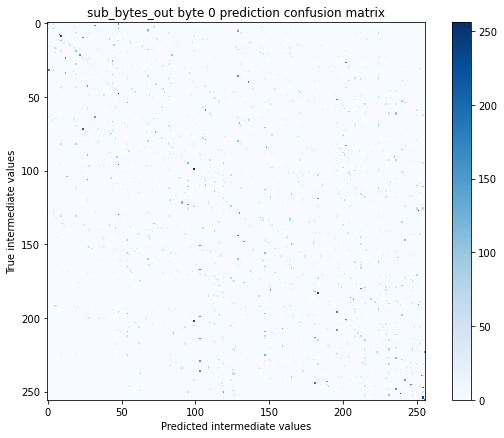

In [99]:
plot_confusion_matrix(y_true, y_pred, normalize=True, title="%s byte %s prediction confusion matrix" % (ATTACK_POINT, ATTACK_BYTE))

## Hypertuning

Posto su rezultati treninga "na slepo" nezavidni, bice koriscen tuner hiperparametara keras ekosistema.

In [8]:
min_layers = 4
max_layers = 10

min_units = 50
max_units = 1000

def build_model(hp):
    
    inputs = keras.Input(shape = (input_vector_shape,))
    
    x = inputs
    
    no_layers = hp.Int('num_layers', min_value=min_layers, max_value=max_layers)
    for layer in range(no_layers):
        
        x = keras.layers.Dense(units = hp.Int('units', min_value=min_units, max_value=max_units, step=50),
                               activation = 'relu')(x)
        
        # Optimize for batch normalization
        if layer == int(no_layers/2) and hp.Boolean('BatchNormalize'):
            x = keras.layers.BatchNormalization()(x)
        

    outputs = keras.layers.Dense(units=256, activation='softmax')(x)
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5, 3e-2, 3e-3, 3e-4, 3e-5, 5e-2, 5e-3, 5e-4, 5e-5])

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    loss="categorical_crossentropy",
                    metrics=['accuracy',
                             'Recall'])

    return model

#### RandomSearch

In [31]:
r_tuner = kt.RandomSearch(hypermodel=build_model,
                    objective='val_accuracy',
                    max_trials=30,
                    executions_per_trial=1,
                    directory=log_root_path + '/hyperparam_tuning/RandomSearch')

r_tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project ./logs//hyperparam_tuning/RandomSearch\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from ./logs//hyperparam_tuning/RandomSearch\untitled_project\tuner0.json
Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 10, 'step': 1, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 1000, 'step': 50, 'sampling': None}
BatchNormalize (Boolean)
{'default': False, 'conditions': []}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05, 0.03, 0.003, 0.0003, 3e-05, 0.05, 0.005, 0.0005, 5e-05], 'ordered': True}


In [ ]:
tensorboard_path  = log_root_path + '/hyperparam_tuning/RandomSearch'

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
tensorboard_callback = tf.keras.callbacks.TensorBoard(tensorboard_path)

r_tuner.search(X_train, 
             y_train, 
             epochs=10, 
             validation_data=(X_test, y_test), 
             callbacks=[early_stop_callback,
                       tensorboard_callback]
            )

Trial 28 Complete [00h 02m 54s]
val_accuracy: 0.00390625

Best val_accuracy So Far: 0.14337158203125
Total elapsed time: 03h 33m 29s

Search: Running Trial #29

Hyperparameter    |Value             |Best Value So Far 
num_layers        |5                 |9                 
units             |200               |750               
BatchNormalize    |True              |True              
learning_rate     |0.0003            |3e-05             

Epoch 1/10
2048/2048 [==============================] - 29s 13ms/step - loss: 5.5526 - accuracy: 0.0039 - recall: 0.0000e+00 - val_loss: 5.5451 - val_accuracy: 0.0039 - val_recall: 0.0000e+00
Epoch 2/10
2048/2048 [==============================] - 30s 15ms/step - loss: 5.0975 - accuracy: 0.0115 - recall: 4.5776e-05 - val_loss: 4.7397 - val_accuracy: 0.0152 - val_recall: 1.5259e-05
Epoch 3/10
2048/2048 [==============================] - 27s 13ms/step - loss: 4.2902 - accuracy: 0.0288 - recall: 9.4604e-04 - val_loss: 4.5892 - val_accuracy: 0.0219 - 

#### Hyperband

In [48]:
h_tuner = kt.Hyperband(
    hypermodel=build_model,
    objective='val_accuracy',
    max_epochs=75,
    hyperband_iterations=10,
    directory=log_root_path + '/hyperparam_tuning/RandomSearch'
)

h_tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 10, 'step': 1, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 1000, 'step': 50, 'sampling': None}
BatchNormalize (Boolean)
{'default': False, 'conditions': []}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05, 0.03, 0.003, 0.0003, 3e-05, 0.05, 0.005, 0.0005, 5e-05], 'ordered': True}


In [ ]:
tensorboard_path  = log_root_path + '/hyperparam_tuning/Hyperband'

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
tensorboard_callback = tf.keras.callbacks.TensorBoard(tensorboard_path)

h_tuner.search(X_train, 
             y_train, 
             epochs=10, 
             validation_data=(X_test, y_test), 
             callbacks=[early_stop_callback,
                       tensorboard_callback]
            )

Trial 73 Complete [00h 22m 24s]
val_accuracy: 0.007199999876320362

Best val_accuracy So Far: 0.007199999876320362
Total elapsed time: 05h 48m 13s

Search: Running Trial #74

Value             |Best Value So Far |Hyperparameter
4                 |6                 |num_layers
950               |350               |units
True              |True              |BatchNormalize
1e-05             |3e-05             |learning_rate
75                |75                |tuner/epochs
25                |25                |tuner/initial_epoch
2                 |2                 |tuner/bracket
2                 |2                 |tuner/round
0069              |0068              |tuner/trial_id

Epoch 26/75
1563/1563 [==============================] - 78s 49ms/step - loss: 5.6293 - accuracy: 0.0045 - recall: 0.0000e+00 - val_loss: 5.6531 - val_accuracy: 0.0035 - val_recall: 0.0000e+00
Epoch 27/75
1563/1563 [==============================] - 76s 49ms/step - loss: 5.5674 - accuracy: 0.0046 - recall: 0

In [ ]:
MLP_functional.summary()

In [ ]:
tf.keras.utils.plot_model(MLP_functional, show_shapes=True)

In [ ]:
MLP_test_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

MLP_functional.compile(loss='categorical_crossentropy', 
                 optimizer=MLP_test_optimizer, 
                 metrics=['accuracy', 'Recall'])

In [ ]:
from datetime import datetime

log_dir = './logs/' + 'MLP_' + datetime.now().strftime("%Y-%d-%m_%H-%M")

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
]

history = MLP_test.fit(
    X_train_reduced,
    y_train,
    batch_size=32,
    epochs=10,
    verbose=1,
    validation_data = (X_test_reduced, y_test),
    callbacks=callbacks_list
)

### Run full training on best MLP

In [10]:
ATTACK_POINT = 'sub_bytes_out'
ATTACK_BYTE = 0

(X_train, y_train) = dataset.create_data(training_array, ATTACK_POINT, ATTACK_BYTE, 40000)
(X_test, y_test, keys, plaintexts) = dataset.create_data(testing_array, ATTACK_POINT, ATTACK_BYTE, 40000, attack = True)
input_vector_shape = X_train.shape[1]

Loading shards: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [01:09<00:00,  3.67it/s]


In [11]:
# Reload tuner

r_tuner = kt.RandomSearch(hypermodel=build_model,
                    objective='val_accuracy',
                    max_trials=30,
                    executions_per_trial=1,
                    directory=log_root_path + '/hyperparam_tuning/RandomSearch')

INFO:tensorflow:Reloading Oracle from existing project ./logs//hyperparam_tuning/RandomSearch\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from ./logs//hyperparam_tuning/RandomSearch\untitled_project\tuner0.json


In [25]:
# Reconstruct the model with best parameters and run full training
best_MLP_cfg = r_tuner.get_best_hyperparameters()[0].values
print("===========================================")
r_tuner.results_summary(3)

Results summary
Results in ./logs//hyperparam_tuning/RandomSearch\untitled_project
Showing 3 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
num_layers: 10
units: 700
BatchNormalize: True
learning_rate: 1e-05
Score: 0.1543121337890625
Trial summary
Hyperparameters:
num_layers: 9
units: 750
BatchNormalize: True
learning_rate: 3e-05
Score: 0.14337158203125
Trial summary
Hyperparameters:
num_layers: 5
units: 200
BatchNormalize: True
learning_rate: 0.0003
Score: 0.1415557861328125


In [24]:
def build_model_from_config(config):
    
    inputs = keras.Input(shape = (input_vector_shape,))
    
    x = inputs
    
    no_layers = config['num_layers']
    for layer in range(no_layers):
        
        x = keras.layers.Dense(units = config['units'], activation = 'relu')(x)
        
        # Optimize for batch normalization
        if layer == int(no_layers/2) and config['BatchNormalize']:
            x = keras.layers.BatchNormalization()(x)
        

    outputs = keras.layers.Dense(units=256, activation='softmax')(x)
    
    learning_rate = config['learning_rate']

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    loss="categorical_crossentropy",
                    metrics=['accuracy',
                             'Recall'])

    return model

In [27]:
def train_model(model, X_train, y_train, batch_size, epochs, validation_data, callbacks_list=None, nn_type='MLP', tag='', save_dir=''):
  
  _date = datetime.now().strftime("%Y-%d-%m_%H-%M")

  _save_dir = './models/' + save_dir + '_' + _date + '[' + tag + ']' 
  _log_dir =  './logs/' + nn_type + '_' + _date + '[' + tag + ']'

  if callbacks_list is None:
    callbacks_list = [
      tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3),
      tf.keras.callbacks.TensorBoard(log_dir=_log_dir, histogram_freq=1)
    ]

  history = model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=validation_data, callbacks=callbacks_list)

  model.save(_save_dir)

  return history

In [26]:
best_MLP = build_model_from_config(best_MLP_cfg)

In [30]:
mlp_best_history = train_model(best_MLP, X_train, y_train, 200, 75, (X_test, y_test), tag='MLP_best')

Epoch 1/75
328/328 [==============================] - 111s 338ms/step - loss: 5.5482 - accuracy: 0.0041 - recall: 0.0000e+00 - val_loss: 5.5468 - val_accuracy: 0.0036 - val_recall: 0.0000e+00
Epoch 2/75
328/328 [==============================] - 93s 284ms/step - loss: 5.5466 - accuracy: 0.0045 - recall: 0.0000e+00 - val_loss: 5.5608 - val_accuracy: 0.0039 - val_recall: 0.0000e+00
Epoch 3/75
328/328 [==============================] - 89s 272ms/step - loss: 5.5461 - accuracy: 0.0039 - recall: 0.0000e+00 - val_loss: 5.5657 - val_accuracy: 0.0040 - val_recall: 0.0000e+00
Epoch 4/75
328/328 [==============================] - 111s 338ms/step - loss: 5.5455 - accuracy: 0.0038 - recall: 0.0000e+00 - val_loss: 5.5592 - val_accuracy: 0.0038 - val_recall: 0.0000e+00
Epoch 5/75
328/328 [==============================] - 111s 338ms/step - loss: 5.5449 - accuracy: 0.0041 - recall: 0.0000e+00 - val_loss: 5.5508 - val_accuracy: 0.0037 - val_recall: 0.0000e+00
Epoch 6/75
328/328 [======================

In [43]:
### Evaluate best MLP

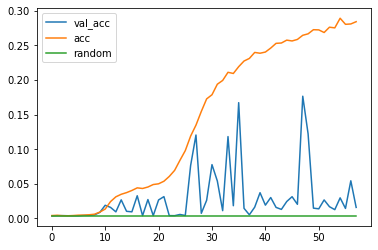

In [33]:
random_accuracy = [1/256] * len(mlp_best_history.history['val_accuracy'])

plt.plot(mlp_best_history.history['val_accuracy'])
plt.plot(mlp_best_history.history['accuracy'])
plt.plot(random_accuracy)
plt.legend(['val_acc', 'acc', 'random'],loc='best')
plt.show()

In [38]:
from collections import defaultdict

y_pred = []
y_true = []
model_metrics = {"acc": tf.metrics.Accuracy()}
correct_prediction_rank = defaultdict(list)
aes = AES()

In [39]:
for attack_trace in tqdm(range(256)):
    attack_traces = X_test[attack_trace*256:attack_trace*256+256,:,:]
    predictions = best_MLP.predict(attack_traces)
    
    predictions_cat = np.argmax(predictions, axis=1)
    true_labels = np.argmax(y_test[attack_trace*256:attack_trace*256+256,:], axis=1)
    
    key_preds = []
    for s, p in zip(predictions_cat, plaintexts):
        aes.reverse_aes(s, p)
    
    for metric in model_metrics.values():
        metric.update_state(true_labels, predictions_cat)
    # for the confusion matrix
    y_pred.extend(predictions_cat)
    y_true.extend(true_labels)
        
    key = keys[0] # all the same in the same shard - not used in real attack
    vals = np.zeros((256))
    for trace_count, kp in enumerate(key_preds):
        vals = vals  + np.log10(kp + 1e-22) 
        guess_ranks = (np.argsort(vals, )[-256:][::-1])
        byte_rank = list(guess_ranks).index(key)
        correct_prediction_rank[trace_count].append(byte_rank)

  0%|          | 0/256 [00:00<?, ?it/s]

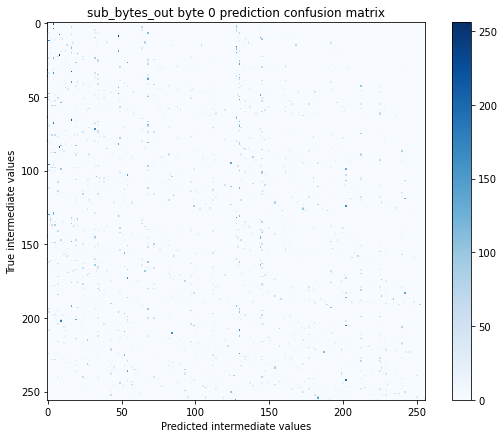

In [42]:
plot_confusion_matrix(y_true, y_pred, normalize=True, title="%s byte %s prediction confusion matrix" % (ATTACK_POINT, ATTACK_BYTE))

In [ ]:
prediction_success = np.sum(np.all(prediction_classes == labels, axis=1))
print(f"Model accuracy: {(prediction_success/X_train_.shape[0]) * 100}%")

In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters()
best_hyperparameters[0].get('layers')

In [ ]:
import keras_tuner as kt

In [ ]:
# Sequential model builder

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten())
    
    for no_layers in range(hp.Int('num_layers', min_value=4, max_value=10)):
        model.add(
            keras.layers.Dense(
                units = hp.Int('units', min_value=500, max_value=5000, step=1000),
                activation = 'relu'
            )
        )

    model.add(keras.layers.Dense(units=256, activation='softmax'))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
#     hp_learning_rate = hp.Float("lr", min_value=1e-5, max_value=1e-2, sampling="log")

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    loss="categorical_crossentropy",
                    metrics=['accuracy'])

    return model

In [ ]:
tuner = kt.Hyperband(hypermodel=build_model,
                    objective='val_accuracy',
                    max_epochs=5,
                    hyperband_iterations=10)

tuner.search_space_summary()

In [ ]:
tensorboard_path = "/logs"
intermediate_path = "/logs/tmp"

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
tensorboard_callback = tf.keras.callbacks.TensorBoard(tensorboard_path)

tuner.search(X_train[:,:20000,:], 
             y_train, 
             epochs=10, 
             validation_data=(X_test[:,:20000,:], y_test), 
             callbacks=[early_stop_callback,
                       tensorboard_callback]
                         )

In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters()

In [ ]:
best_hyperparameters[0].get('layers')

### ResNet

### CNN (Convolutional Neural Network)

In [ ]:
def display_config(config_name, config):
    """Pretty print a config object in terminal.
    Args:
        config_name (str): name of the config
        config (dict): config to display
    """
    cprint(f"[{config_name}]", "magenta")
    cnt = 1
    for k, v in config.items():
        if cnt % 2:
            color = "cyan"
        else:
            color = "yellow"
        cprint(f"{k}:{v}", color)
        cnt += 1

In [ ]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""Intro model."""

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

def block(x,
          filters,
          kernel_size=3,
          strides=1,
          conv_shortcut=False,
          activation="relu"):
    """Residual block with pre-activation
    From: https://arxiv.org/pdf/1603.05027.pdf

    Args:
        x: input tensor.
        filters (int): filters of the bottleneck layer.

        kernel_size(int, optional): kernel size of the bottleneck layer.
        defaults to 3.

        strides (int, optional): stride of the first layer.
        defaults to 1.

        conv_shortcut (bool, optional): Use convolution shortcut if True,
        otherwise identity shortcut. Defaults to False.

        use_batchnorm (bool, optional): Use batchnormalization if True.
        Defaults to True.

        activation (str, optional): activation function. Defaults to "relu".

    Returns:
        Output tensor for the residual block.
    """

    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)

    if conv_shortcut:
        shortcut = layers.Conv1D(4 * filters, 1, strides=strides)(x)
    else:
        if strides > 1:
            shortcut = layers.MaxPooling1D(1, strides=strides)(x)
        else:
            shortcut = x

    x = layers.Conv1D(filters, 1, use_bias=False, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)

    x = layers.Conv1D(filters,
                      kernel_size,
                      strides=strides,
                      use_bias=False,
                      padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)

    x = layers.Conv1D(4 * filters, 1)(x)
    x = layers.Add()([shortcut, x])
    return x


def stack(x, filters, blocks, kernel_size=3, strides=2, activation="relu"):
    """A set of stacked residual blocks.
    Args:
        filters (int): filters of the bottleneck layer.

        blocks (int): number of conv blocks to stack.

        kernel_size(int, optional): kernel size of the bottleneck layer.
        defaults to 3.

        strides (int, optional): stride used in the last block.
        defaults to 2.

        conv_shortcut (bool, optional): Use convolution shortcut if True,
        otherwise identity shortcut. Defaults to False.

        activation (str, optional): activation function. Defaults to "relu".

    Returns:
        tensor:Output tensor for the stacked blocks.
  """
    x = block(x,
              filters,
              kernel_size=kernel_size,
              activation=activation,
              conv_shortcut=True)
    for _ in range(2, blocks):
        x = block(x, filters, kernel_size=kernel_size, activation=activation)
    x = block(x, filters, strides=strides, activation=activation)
    return x


def Resnet1D(input_shape, attack_point, mdl_cfg, optim_cfg):  # pylint: disable=C0103
    del attack_point  # unused

    pool_size = mdl_cfg["initial_pool_size"]
    filters = mdl_cfg["initial_filters"]
    block_kernel_size = mdl_cfg["block_kernel_size"]
    activation = mdl_cfg["activation"]
    dense_dropout = mdl_cfg["dense_dropout"]
    num_blocks = [
        mdl_cfg["blocks_stack1"], mdl_cfg["blocks_stack2"],
        mdl_cfg["blocks_stack3"], mdl_cfg["blocks_stack4"]
    ]

    inputs = layers.Input(shape=(input_shape))
    x = inputs

    # stem
    x = layers.MaxPool1D(pool_size=pool_size)(x)

    # trunk: stack of residual block
    for block_idx in range(4):
        filters *= 2
        x = stack(x,
                  filters,
                  num_blocks[block_idx],
                  kernel_size=block_kernel_size,
                  activation=activation)

    # head model: dense
    x = layers.GlobalAveragePooling1D()(x)
    for _ in range(1):
        x = layers.Dropout(dense_dropout)(x)
        x = layers.Dense(256)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)

    outputs = layers.Dense(256, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.summary()

    lr = optim_cfg["lr"]

    model.compile(loss=["categorical_crossentropy"],
                  metrics=["acc"],
                  optimizer=Adam(lr))
    return model


def get_model(input_shape, attack_point, config):
    """Return an instantiated model based of the config provided.

    Args:
        config (dict): scald config.
    """

    mdl_cfg = config["model_parameters"]
    optim_cfg = config["optimizer_parameters"]

    display_config("model", mdl_cfg)
    display_config("optimizer", optim_cfg)
    return Resnet1D(input_shape, attack_point, mdl_cfg, optim_cfg)

In [ ]:
from cprint import cprint

In [ ]:
cfg = {
    "model": "cnn",
    "device": "stm32f415",
    "algorithm": "tinyaes",
    "version": "10",
    "attack_points": [
        "sub_bytes_out"
    ],
    "attack_bytes": [
        "0"
    ],
    "max_trace_len": 10000,
    "num_shards": 256,
    "num_traces_per_shard": 256,
    "batch_size": 32,
    "epochs": 10,
    "optimizer_parameters": {
        "lr": 0.001,
        "multi_gpu_lr": 0.001
    },
    "model_parameters": {
        "activation": "relu",
        "initial_filters": 8,
        "initial_pool_size": 4,
        "block_kernel_size": 3,
        "blocks_stack1": 3,
        "blocks_stack2": 4,
        "blocks_stack3": 4,
        "blocks_stack4": 3,
        "dense_dropout": 0.1
    }
}

In [ ]:
from termcolor import cprint

In [ ]:
model_scaml = get_model(X_train[:,:20000,:].shape[1:], 'sub_bytes_out', cfg )

In [ ]:
y_test

In [ ]:
model_scaml.fit(X_train[:,:20000,:],
          y_train,
          validation_data=(X_test[:,:20000,:], y_test),
          verbose=1,
          epochs=cfg["epochs"])

In [ ]:
scaml_predictions = model_scaml.predict(X_test[:,:20000,:], verbose=1)

In [ ]:
scaml_predictions

In [ ]:
print(np.argmax(scaml_predictions, axis=1).shape)
print(np.argmax(scaml_predictions, axis=1))

In [ ]:
print(training_data[0]['sub_bytes_out'])

In [ ]:
model_scaml.save(models_path + '/scaml_model_trained')

# Tips:

## start simple (underfit) or start complex (overfit)

## Don't need great accuracy => slightly above random could work with enough traces